In [1]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA

In [2]:
# Haritalar 2D temel verinde denenir ( 2 qubit ile)
num_features = 2
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)

ansatz = RealAmplitudes(num_qubits=num_features, reps=1)

Quantum devre bileşenleri başlatıldı.


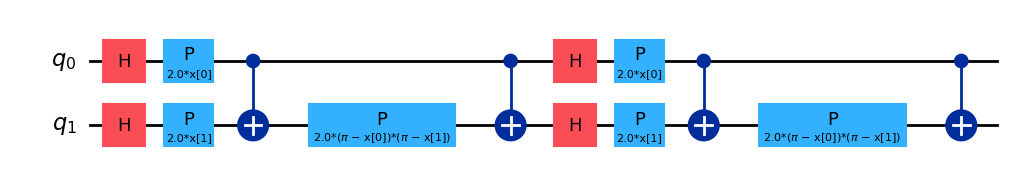

In [3]:
# for VQC
# VQC parametrelerini ayarla
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100)
)
print("Quantum devre bileşenleri başlatıldı.")
# ek olarak feature map görselleştirme
feature_map.decompose().draw('mpl')

Devreyi veri setinde kullanmak

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

iris = datasets.load_iris()
X, y = iris.data, iris.target

# Standart ölçekleme ve PCA ile 2 bileşene indirgemek
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# veriyi eğitim ve test setlerine ayırmak
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [9]:
# eğitilebilir katman tanımı
# reps=3 default olarak bırakılabilir ama istenirse değiştirilebilir değişirse sonuçlar nasıl değişir?
ansatz_devresi = RealAmplitudes(num_qubits=2, reps=3) 

In [10]:
# VQC Modelinin kurulumı
kuantum_siniflandirici = VQC(
    feature_map=feature_map, # az önce çizdirdiğin veri kodlama devresi
    ansatz=ansatz_devresi,   # Eğitilebilir parametreli
    optimizer=COBYLA(maxiter=80), # İterasyon sayısını 80 ile sınırla
    sampler=None             # Varsayılan Aer 
)

In [11]:
# Eğitim süreci
print("Kuantum eğitimi başlatıldı...")
baslangic_zamani = time.time()
kuantum_siniflandirici.fit(X_train, y_train) #  Eğitim verisi ile model eğitimi
bitis_zamani = time.time()

# Performans değerlendirmesi
basari_skoru = kuantum_siniflandirici.score(X_test, y_test)
egitim_suresi = bitis_zamani - baslangic_zamani

print(f"Kuantum VQC Başarı Oranı: %{basari_skoru * 100:.2f}")
print(f"Toplam Eğitim Süresi: {egitim_suresi:.2f} saniye") 

Kuantum eğitimi başlatıldı...
Kuantum VQC Başarı Oranı: %42.22
Toplam Eğitim Süresi: 13.46 saniye


şimdi başarı oranını geliştirmeyi planlıyom

Senaryo 1 Parametre değişimi
Optimizer iterasyon sayısını artırarak modelin iyileşmesini planlıyorum

In [15]:
from qiskit_algorithms.optimizers import SPSA
iterasyon_listesi = [50, 100, 200] # Farklı deneme noktaları

for iter_sayisi in iterasyon_listesi:
    print(f"\n {iter_sayisi} İterasyon ile Deney Başlıyor ")
    
    vqc_parametre_testi = VQC(
        feature_map=feature_map,
        ansatz=ansatz_devresi,
        optimizer=SPSA(maxiter=iter_sayisi), # İterasyon sayısını değiştir
        sampler=None
    )
    
    basla = time.time()
    vqc_parametre_testi.fit(X_train, y_train) # eğitim
    sure = time.time() - basla
    
    skor = vqc_parametre_testi.score(X_test, y_test)
    print(f"Sonuç -> Başarı: %{skor*100:.2f} | Süre: {sure:.2f} sn")


--- 50 İterasyon ile Deney Başlıyor ---
Sonuç -> Başarı: %40.00 | Süre: 26.19 sn

--- 100 İterasyon ile Deney Başlıyor ---
Sonuç -> Başarı: %42.22 | Süre: 43.54 sn

--- 200 İterasyon ile Deney Başlıyor ---
Sonuç -> Başarı: %42.22 | Süre: 74.40 sn


In [16]:
# hiçbir şey değişmeden SPSA optimizasyonu ile iterasyon sayısının etkisi test edilmiş oldu

Senaryo 2 Ansatz değişimi
 İterasyon sabit, devre yapısı farklı

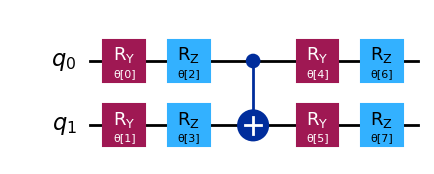

In [18]:
from qiskit.circuit.library import EfficientSU2
mimariler = {
    "Sığ Devre": EfficientSU2(num_qubits=2, reps=1, entanglement='linear'),
    "Derin Devre": EfficientSU2(num_qubits=2, reps=4, entanglement='full')
}
# devreyi göster
mimariler["Sığ Devre"].decompose().draw('mpl')

In [19]:
for isim, devre in mimariler.items():
    print(f"\n Mimari Deneyi: {isim} ")
    
    vqc_mimari_testi = VQC(
        feature_map=feature_map,
        ansatz=devre, # mimari değişimi 
        optimizer=SPSA(maxiter=100),
        sampler=None
    )
    
    vqc_mimari_testi.fit(X_train, y_train)
    skor = vqc_mimari_testi.score(X_test, y_test)
    print(f"{isim} Başarı Oranı: %{skor*100:.2f}")


 Mimari Deneyi: Sığ Devre 
Sığ Devre Başarı Oranı: %40.00

 Mimari Deneyi: Derin Devre 
Derin Devre Başarı Oranı: %42.22


In [ ]:
# yeni devrelerle SPSA optimizasyonu ile iterasyon sayısının etkisi test edilmiş oldu

In [20]:
# araştırmaya devam edilebilir kısım